# Machine Learning

## Import Libraries

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import color maps
import matplotlib.cm as cm
# import tokenizer
#from nltk import word_tokenize
import string
# import model related libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, _forest
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, fbeta_score, classification_report, silhouette_samples, silhouette_score
from sklearn.model_selection import learning_curve
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# import a function that convert items into a callable object
from operator import itemgetter
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

pd.options.display.max_colwidth = 200
%matplotlib inline
%run functions.ipynb # import my functions from functions notebook

Stored 'my_stop_words' (list)


## Load Data

In [2]:
# read in doctor's discharge notes from NOTEEVENTS.csv
df_notes = pd.read_csv("../mimic-iii-clinical-database-1.4/NOTEEVENTS.csv")

/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# load master dataframe
master = pd.read_csv('../Capstone 1/master.csv')
master.drop('Unnamed: 0',axis=1,inplace=True)
master.columns

Index(['SUBJECT_ID', 'HADM_ID', 'READMISSION_30DAYS', 'DISCHARGE_LOCATION',
       'INSURANCE', 'MARITAL_STATUS', 'GENDER', 'AGE', 'ETHNICITY_GRP',
       'CURR_SERVICE', 'NUM_PRESCRIPTION', 'LOS', 'HLOS_CL', 'LOS_RATIO', 'KD',
       'HP', 'PUL', 'UT', 'HIV', 'DB', 'MBD', 'TB', 'GA', 'HM', 'HEP', 'HO',
       'FR', 'TX', 'LA', 'AF', 'CB', 'PNE', 'HF', 'SP', 'WMCC', 'WCC',
       'WOCCMCC', 'WOMCC', 'WCCMCC', 'DRG_SEVERITY', 'DRG_MORTALITY', 'TEXT',
       'TEXT_CL', 'AGE_boxcox_lambda_opt', 'NUM_PRESCRIPTION_LOG', 'LOS_LOG',
       'LOS_boxcox_lambda_opt', 'HLOS_CL_LOG', 'HLOS_CL_boxcox_lambda_opt',
       'LOS_RATIO_LOG', 'LOS_RATIO_boxcox_lambda_opt'],
      dtype='object')

Since this project is not only NLP focused, I will only adopt simple NLP techniques that are appropriate for this project.

In [45]:
x_train, x_test, y_train, y_test = train_test_split(master['TEXT_CL'],master.READMISSION_30DAYS,
                                        test_size=0.3,train_size=0.7, random_state = 0)

In [79]:
from sklearn.pipeline import Pipeline
# Pipeline & Gridsearch setup: TFIDF pipeline setup
tvc_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('mb', MultinomialNB())
])

# Setting params for TFIDF Vectorizer gridsearch
tf_params = {
    'tvec__min_df':[5, 10],
    'tvec__max_features':[1000, 3000],
    'tvec__stop_words': [None, my_stop_words],
    'mb__alpha': np.linspace(0.5, 1.5, 6),
    'mb__fit_prior': [True, False], 
}

# Setting up GridSearch for TFIDFVectorizer
tvc_gs = GridSearchCV(tvc_pipe, param_grid=tf_params, cv = 5, verbose =1, n_jobs = -1)

# Fitting TVC GS
tvc_gs.fit(x_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 22.5min
/Applications/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 48.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 51.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [80]:
print(tvc_gs.score(x_train, y_train))
print(tvc_gs.score(x_test, y_test))

0.7313843508168529
0.7308463698355395


In [81]:
tvc_gs.best_params_

{'mb__alpha': 0.5,
 'mb__fit_prior': True,
 'tvec__max_features': 1000,
 'tvec__min_df': 5,
 'tvec__stop_words': None}

In [83]:
# TfidfVectorizer is used instead of CountVectorizer because the former performs better with the return frequency ratio instead of count only
# set min_df to 5 to avoid using words that only appeared once or twice
vect = TfidfVectorizer(min_df=5, max_features = 1000, lowercase=True, tokenizer=tokenizer_better,
                       stop_words=my_stop_words, use_idf=True)


In [84]:
# extract word features from TEXT
feature_words = vect.fit_transform(master['TEXT_CL'].values)

In [98]:
feature_words.shape[1]

1000

## Term frequency Analysis

In [75]:
# create sparse matrix containing terms and document frequencies that are predictive of the positive and negative class
neg_doc_matrix = vect.transform(
    df_clean[df_clean.READMISSION_30DAYS == 0].TEXT)
pos_doc_matrix = vect.transform(
    df_clean[df_clean.READMISSION_30DAYS == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix, axis=0)
pos_tf = np.sum(pos_doc_matrix, axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
# combine the spare matrices into a dataframe to derive the total doc_frequencies for each term
term_freq_df = pd.DataFrame(
    [neg, pos], columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
tablet,992.310520,387.836987,1380.147507
po,749.073190,297.585820,1046.659010
no,761.600327,273.076868,1034.677195
sig,679.406843,275.779843,955.186686
daily,593.022781,241.891088,834.913869
blood,563.193389,206.758499,769.951888
discharge,538.197847,193.151320,731.349166
day,531.507935,190.970588,722.478523
hospital,484.480507,189.041886,673.522393
last,415.675433,151.579933,567.255366


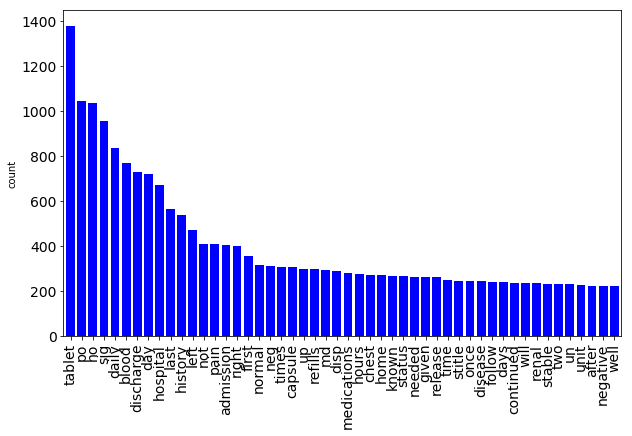

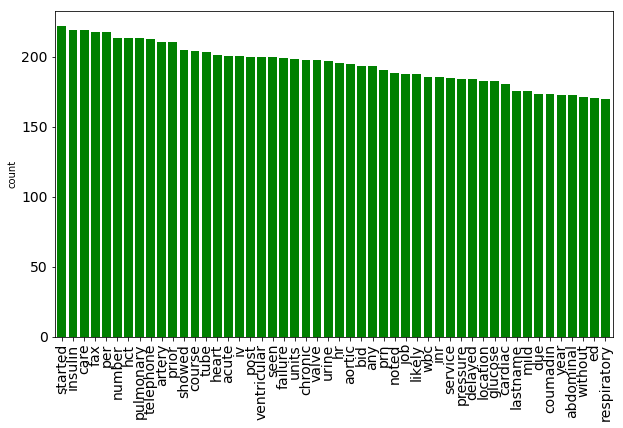

In [76]:
# create a series from the sparse matrix
d = pd.Series(term_freq_df.total,
              index=term_freq_df.index).sort_values(ascending=False)
# plot term frequency for first 50 words
ax = d[:50].plot(kind='bar', figsize=(10, 6), width=.8,
                 fontsize=14, rot=90, color='b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()
# plot term frequency for 50th to 100th words
ax = d[50:100].plot(kind='bar', figsize=(10, 6), width=.8,
                    fontsize=14, rot=90, color='g')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

## Building NLP Model

In [85]:
# splitting dataset for training and testing
Xtrain_w, Xtest_w, y_train_w, y_test_w = train_test_split(feature_words,master.READMISSION_30DAYS,
                                        test_size=0.3,train_size=0.7, random_state = 0)

In [97]:
# build and evaluate a Multinomial Naive Bayes model using only word features from discharge notes
model = MultinomialNB(alpha = 1, fit_prior = True)
clf = model.fit(Xtrain_w, y_train_w)

y_train_preds = clf.predict_proba(Xtrain_w)[:,1]
y_valid_preds = clf.predict_proba(Xtest_w)[:,1]

auc_train = roc_auc_score(y_train_w, y_train_preds)
auc_valid = roc_auc_score(y_test_w, y_valid_preds)

print ("AUC on training data: ","{0:.3%}".format(auc_train))
print ("AUC on test data: ","{0:.3%}".format(auc_valid))

AUC on training data:  65.504%
AUC on test data:  63.376%


In [92]:
from sklearn.metrics import classification_report, confusion_matrix

y_valid_pred_class = pd.Series(y_valid_preds).apply(lambda x: 1.0 if x >= 0.39 else 0.0)
print('threshold probability: 0.35')
print(classification_report(y_test, y_valid_pred_class))

tn, fp, fn, tp = (confusion_matrix(y_test, y_valid_pred_class).ravel())
print('tn: ',tn,'fp: ',fp,'fn: ',fn,'tp: ',tp)

threshold probability: 0.35
              precision    recall  f1-score   support

         0.0       0.74      0.95      0.84      1822
         1.0       0.45      0.10      0.17       671

    accuracy                           0.73      2493
   macro avg       0.60      0.53      0.50      2493
weighted avg       0.66      0.73      0.66      2493

tn:  1740 fp:  82 fn:  603 tp:  68


## What are the strongly predictive features?

Below is a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [19]:
# plot the top 10 words that are most predictive of the positive and negative class
words = np.array(vect.get_feature_names())

x = np.eye(Xtest_w.shape[1])
probs = clf.predict_proba(x)[:, 1]
ind = np.argsort(probs) # returned index of probs sorted in ascending order

wk_words = words[ind[:10]]
strg_words = words[ind[-10:]]

wk_prob = probs[ind[:10]]
strg_prob = probs[ind[-10:]]

print("High probability readmission words\tP(readmit<30 | word)")
for w, p in zip(strg_words, strg_prob):
    print("{:>20}".format(w), "{:.4f}".format(p))
    
print("Low probability readmission words\tP(readmit<30 | word)")
for w, p in zip(wk_words, wk_prob):
    print("{:>20}".format(w), "{:.4f}".format(p))

High probability readmission words	P(readmit<30 | word)
   echocardiographic 0.4207
        transitional 0.4214
               trach 0.4236
                 peg 0.4252
                  br 0.4275
             lifting 0.4311
        neurosurgery 0.4330
          herniation 0.4780
                 sdh 0.5471
            subdural 0.5592
Low probability readmission words	P(readmit<30 | word)
             suicide 0.1467
               crohn 0.1494
     catheterization 0.1579
         phosphatase 0.1673
         nephrostomy 0.1683
            alkaline 0.1701
                ptca 0.1735
             norvasc 0.1787
       postoperative 0.1797
   electrocardiogram 0.1832
